## Feature Selection (AER)


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import f_classif, chi2, f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
import pandas as pd
import urllib.request as urllib
import sys
import warnings
warnings.filterwarnings('ignore')
from numpy import array
from ipywidgets import widgets
#Import pandas_profiling


In [2]:
import pandas as pd
df = pd.read_json('prueba_v7_1_json_for_pandas.json')


In [3]:
aer_1 = pd.read_csv('longitudinal_AER.csv', sep='\t')


In [4]:
df_visita1 = pd.read_csv('visita1.csv')
df_seqn_sample = pd.read_csv('SEQN_SAMPLE_PESA.csv', sep='\t')

df_visita1 = pd.merge(df_visita1, df_seqn_sample, left_on='SEQN', right_on='SEQN')
df_visita1['BirthDate'] = pd.to_datetime(df_visita1['BirthDate'], infer_datetime_format=True)
df_visita1['LabExtDate'] = pd.to_datetime(df_visita1['LabExtDate'], infer_datetime_format=True)
df_visita1['dias'] =  (df_visita1['LabExtDate'] - df_visita1['BirthDate']).dt.days ### devuelve una serie con los dias en formato int64
df_visita1['AGE'] = df_visita1['dias']/365.2425 ### transformado en año diviendo por el año gregoriano


In [5]:
df_aer_phenotype = pd.merge(df_visita1, aer_1, left_on='ID', right_on='SAMPLE_VIS1')


In [6]:
df = df[df['FILTER_2']==1]
#df_1['INTERNALLY_IDENTIFIED'] = df_1['INTERNALLY_IDENTIFIED'].fillna('False')
df = df[df['ref'] != '']
df = df[df['ref'].notnull()]
df = df.drop(columns=['MutationTaster_AAE','MutPred_Top5features',
                      'MutPred_AAchange','SiPhy_29way_pi', 'CANONICAL',
                      'CADD_phred_hg19','CADD_raw_hg19', 'CADD_raw_rankscore_hg19',
                      'Mastermind_MMID3', 'genename', 'Ensembl_geneid',
                      'clinvar_hgvs', 'ENSP','Feature', 'SEQQ',
                      'Mastermind_counts', 'HGVSc', 'HGVSp','Ensembl_proteinid',
                      'Ensembl_transcriptid', 'Codons', 'Existing_variation', 'MANE_SELECT',
                      'gnomAD_NFE_AF','HGVSc_ANNOVAR','HGVSc_VEP', 'HGVSc_snpEff',
                      'HGVSp_ANNOVAR', 'HGVSp_VEP', 'HGVSp_snpEff','hg19_chr', 'rs_dbSNP"'])

df['INTERNALLY_IDENTIFIED'] = df['INTERNALLY_IDENTIFIED'].fillna(0)

df.loc[df['INTERNALLY_IDENTIFIED'] != 0, 'INTERNALLY_IDENTIFIED'] = 1
df.loc[df['COSMIC_N_MATCH'] != 0, 'COSMIC_N_MATCH'] = 1
df.loc[df['PREVIOUSLY_IDENTIFIED'] == True , 'PREVIOUSLY_IDENTIFIED'] = 1
df.loc[df['PREVIOUSLY_IDENTIFIED'] == False , 'PREVIOUSLY_IDENTIFIED'] = 0
df['DRIVER'] = df['INTERNALLY_IDENTIFIED']
df.loc[df['DRIVER'] == 2 , 'DRIVER'] = 1
df.loc[df['ARTIFACTS'] == True , 'ARTIFACTS'] = 1
df.loc[df['ARTIFACTS'] == False , 'ARTIFACTS'] = 0

#df = df.set_index('variantInternalId')
df.STDEV_VAF = df['STDEV_VAF'].replace('NA', '0')
df.COSMIC_MATCH = df['COSMIC_MATCH'].replace('', 0)

columns_names = list(df.columns.values)
exceptions = []
for key in columns_names:
    try:
        df[key] = df[key].str.replace(",",".")
        
    except:
        exceptions.append(key)
    try:
        df[key] = df[key].map(lambda x: x.split('&')[0],  na_action = 'ignore')
    except:
        pass


df = df.replace('.', None)
df = df.replace(',', None)
df = df.replace('-', None)
df = df.replace('', None)
#df_1 = df[df['ARTIFACTS']==1]
#df_2 = df[df['DRIVER']==1]
#df = pd.concat([df_2, df_1])

df.drop(columns=['INTERNALLY_IDENTIFIED'])
df.drop(columns=['PREVIOUSLY_IDENTIFIED'])
df.drop(columns=['ARTIFACTS'])

df.drop(columns=['LONGITUDINAL_BOTH'])
df.drop(columns=['LONGITUDINAL_ONLY_VISIT_1'])
df.drop(columns=['LONGITUDINAL_ONLY_VISIT_2'])


,variantInternalId,SIFT_DESC,SIFT_SCORE,POLYPHEN_DESC,POLYPHEN_SCORE,MEAN_VAF,STDEV_VAF,MAX_VAF,FRACTION_SAMPLES,NUM_SAMPLES_WITH_MUTATION,...,phyloP30way_mammalian_rankscore,ref,refcodon,FILTER_1,FILTER_2,RPA,RU,STR,STRQ,DRIVER
140,chr1_1793267_T_A,deleterious,0.04,possibly_damaging,0.913,0.004285,NaN,0.005965,0.002314,10,...,0.64695,T,ACC,1,1,NaN,NaN,NaN,NaN,0
187,chr1_1815775_G_A,deleterious,0.01,probably_damaging,0.974,0.003864,0,0.003864,0.002314,10,...,0.53824,G,CAC,1,1,NaN,NaN,NaN,NaN,0
189,chr1_1815775_G_C,tolerated,0.51,probably_damaging,0.976,0.008626,NaN,0.017000,0.002314,10,...,0.53824,G,CAC,1,1,NaN,NaN,NaN,NaN,0
195,chr1_1815788_C_A,deleterious,0,probably_damaging,1,0.013372,NaN,0.017000,0.000463,2,...,0.15429,C,AAG,1,1,NaN,NaN,NaN,NaN,1
197,chr1_1815790_T_C,deleterious,0,probably_damaging,1,0.006482,NaN,0.040000,0.028466,123,...,0.51903,T,AAG,1,1,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97418,chrY_20582682_T_A,tolerated,0.77,possibly_damaging,0.944,0.023000,NaN,0.027000,0.093265,403,...,0.06483,T,TTG,1,1,NaN,NaN,NaN,NaN,0
97600,chr21_43095697_A_C,deleterious,0,possibly_damaging,0.545,0.071000,0,0.071000,0.000231,1,...,0.94714,A,TTT,1,1,NaN,NaN,NaN,NaN,0
97606,chr21_43095726_C_G,tolerated,0.39,benign,0.056,0.482000,0,0.482000,0.000926,4,...,0.45946,C,GAG,1,1,NaN,NaN,NaN,NaN,0
97607,chr21_43095726_C_A,None,None,None,None,0.510500,NaN,0.684000,0.000926,4,...,0.45946,C,GAG,1,1,NaN,NaN,NaN,NaN,0


In [7]:
df = df[df['variantInternalId'].isin(aer_1.VAR_ID)]
df = df[['variantInternalId', 'DRIVER']]
#df = df[df['variantInternalId'].isin(aer['VAR_ID'])]
#df_aer = pd.merge(df, aer, left_on='variantInternalId', right_on='VAR_ID')
df_aer = pd.merge(df, df_aer_phenotype, left_on='variantInternalId', right_on='VAR_ID')



In [8]:
df_aer = df_aer.replace('.', None)
df_aer = df_aer.replace(',', None)
df_aer = df_aer.replace('-', None)
df_aer = df_aer.replace('', None)

# Filtrado de Features y analisis de los datos 

En html adjunto

In [9]:
"""pandas_profiling_report  = df.profile_report(
    title="Pandas Profiling Report", 
    explorative=True,  #More analysis (Unicode)
    html={'style': 
          {'full_width': True,
           'theme':'flatly'} #available theme options: ‘bootswatch’ ,'flatly','united'
        }, 
    interactions = {'targets' : ['DRIVER']} , #When a list of variable names is given, only interactions between these and all other variables are given.
    progress_bar=True)
pandas_profiling_report.to_file("pandas_profiling_report_AER.html")"""

'pandas_profiling_report  = df.profile_report(\n    title="Pandas Profiling Report", \n    explorative=True,  #More analysis (Unicode)\n    html={\'style\': \n          {\'full_width\': True,\n           \'theme\':\'flatly\'} #available theme options: ‘bootswatch’ ,\'flatly\',\'united\'\n        }, \n    interactions = {\'targets\' : [\'DRIVER\']} , #When a list of variable names is given, only interactions between these and all other variables are given.\n    progress_bar=True)\npandas_profiling_report.to_file("pandas_profiling_report_AER.html")'

<AxesSubplot: >

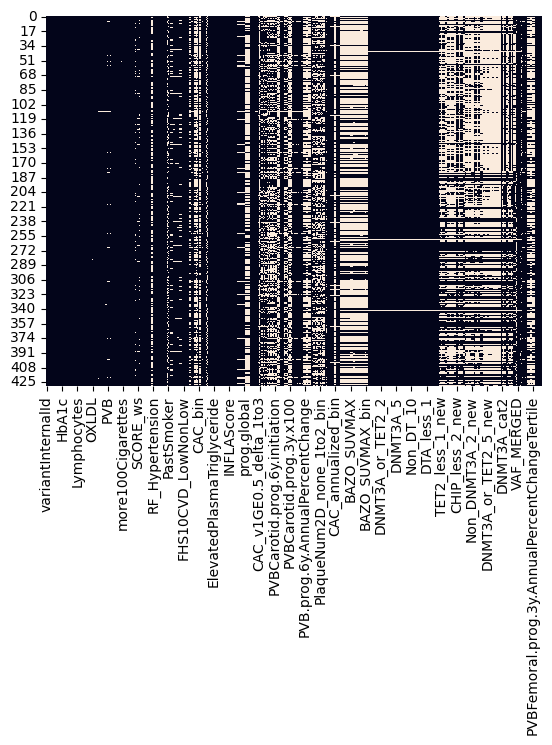

In [10]:
# Identificamos los missing values visualmente
sns.heatmap(df_aer.isnull(), cbar=False)

In [11]:
sumNA = list(df_aer.isnull().sum(axis=0))
sumNA_filtered = []
for NAsum in sumNA:
    sumNA_filtered.append(NAsum < (30*df_aer.shape[0]/100))
df_filtered = df_aer.loc[:, sumNA_filtered]
filtered_columns = list(df_aer.loc[:, ~np.array(sumNA_filtered)].columns.values)
no_filtered_columns = list(df_aer.loc[:, np.array(sumNA_filtered)].columns.values)

In [12]:
string_columns = []
numeric_columns = []

for key in no_filtered_columns:
    try:
        df_filtered[key].dropna(axis=0).astype(float)           
        numeric_columns.append(key)
    except:
        string_columns.append(key)
        df_filtered[key] = df_filtered[key].fillna('NA')


In [13]:
knn_imputer = KNNImputer(n_neighbors = 5)
df_filtered_imputed_numeric = knn_imputer.fit_transform(df_filtered[numeric_columns])
df_filtered_imputed_numeric = pd.DataFrame(df_filtered_imputed_numeric)
df_filtered_imputed_numeric.columns = numeric_columns


In [14]:
len(numeric_columns)

91

In [15]:
#Filtrado de irrelevantes
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9) 
min_variance = 0.15
low_variance = variance_threshold_selector(df_filtered_imputed_numeric, min_variance) 

df_filtered_imputed_numeric_variance = low_variance
numeric_columns = list(df_filtered_imputed_numeric_variance.columns.values)

df_3 = np.concatenate([np.array(df_filtered[string_columns]), df_filtered_imputed_numeric_variance], axis=1)
df_3 = pd.DataFrame(df_3)
df_3.columns = list(string_columns) + list(numeric_columns)
#Filtrado de variables no usadas en modelos
#df_4 = df_3.drop(columns=['VARIANT_CLASS', 'SYMBOL_SOURCE', 'GENCODE_basic', 'Feature_type', 'BIOTYPE'])
####WHITELIST QUITADO AÑADIR AL DROP
##df_4 = df_4.drop(columns=[ 'PREVIOUSLY_IDENTIFIED', 'LONGITUDINAL_BOTH', 'LONGITUDINAL_ONLY_VISIT_1', 'LONGITUDINAL_ONLY_VISIT_2', 'AER'])
df_4 = df_3.drop(columns=[ 'AER'])

In [16]:
"""pandas_profiling_report  = df_4.profile_report(
    title="Pandas Profiling Report", 
    explorative=True,  #More analysis (Unicode)
    html={'style': 
          {'full_width': True,
           'theme':'flatly'} #available theme options: ‘bootswatch’ ,'flatly','united'
        }, 
    interactions = {'targets' : ['DRIVER']} , #When a list of variable names is given, only interactions between these and all other variables are given.
    progress_bar=True)
pandas_profiling_report.to_file("pandas_profiling_report_filtered_imputed.html")"""

'pandas_profiling_report  = df_4.profile_report(\n    title="Pandas Profiling Report", \n    explorative=True,  #More analysis (Unicode)\n    html={\'style\': \n          {\'full_width\': True,\n           \'theme\':\'flatly\'} #available theme options: ‘bootswatch’ ,\'flatly\',\'united\'\n        }, \n    interactions = {\'targets\' : [\'DRIVER\']} , #When a list of variable names is given, only interactions between these and all other variables are given.\n    progress_bar=True)\npandas_profiling_report.to_file("pandas_profiling_report_filtered_imputed.html")'

In [17]:
#df_filtered_imputed_numeric = df_filtered_imputed_numeric.drop(columns=['INTERNALLY_IDENTIFIED', 'PREVIOUSLY_IDENTIFIED', 'ARTIFACTS', 'DRIVER', 'LONGITUDINAL_BOTH', 'LONGITUDINAL_ONLY_VISIT_1', 'LONGITUDINAL_ONLY_VISIT_2'])
df_filtered_imputed_numeric_variance_1 = df_filtered_imputed_numeric_variance.drop(columns=[ 'AER'])
#df_filtered_imputed_numeric_variance_1 = df_filtered_imputed_numeric_variance.drop(columns=['WHITELIST', 'ARTIFACTS', 'INTERNALLY_IDENTIFIED', 'PREVIOUSLY_IDENTIFIED', 'LONGITUDINAL_BOTH', 'LONGITUDINAL_ONLY_VISIT_1', 'LONGITUDINAL_ONLY_VISIT_2', 'DRIVER', 'Gene', 'AER'])

#np.array(df_3['DRIVER'])


#numeric_columns.remove('WHITELIST')


numeric_columns.remove('AER')



In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
df_3['EXPAND'] = 0
df_3.loc[df_3['AER'] > 11 , 'EXPAND'] = 1
y = np.array(df_3['EXPAND']).astype(int)
X = np.array(df_4)
X_1 = pd.DataFrame(df_filtered_imputed_numeric_variance_1)
scaler = preprocessing.StandardScaler()
X_1 = pd.DataFrame(scaler.fit_transform(X_1))
numeric_columns = [item.replace('+', 'plus') for item in numeric_columns]
numeric_columns = [item.replace('-', '_') for item in numeric_columns]

X_1.columns = numeric_columns


#all_columns = all_columns + '+' + '+'.join(list(dummies.columns.values.astype(str)))
#X_1= pd.concat([X_1, dummies], axis = 1)


In [19]:
for lab in np.unique(y):
    n_sam = np.sum(y == lab)
    print("Class %d: %3d samples (%5.2f%%)" % (lab, n_sam, 100.0 * n_sam / len(y)))

Class 0: 320 samples (74.42%)
Class 1: 110 samples (25.58%)


In [20]:
len(numeric_columns)

73

In [21]:


#X_1 = np.array(X_1, dtype=float)
modelo = sm.Logit(endog=y, exog=X_1)
modelo2 = modelo.fit(solver='bfgs')
modelo2.summary()

         Current function value: 0.581299
         Iterations: 35


/data3/220131_PESA_HLA/_env/envs/python34/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  430
Model:                          Logit   Df Residuals:                      362
Method:                           MLE   Df Model:                           67
Date:                Mon, 16 Jan 2023   Pseudo R-squ.:                -0.02227
Time:                        15:21:07   Log-Likelihood:                -249.96
converged:                      False   LL-Null:                       -244.51
Covariance Type:            nonrobust   LLR p-value:                     1.000
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
DRIVER                                          0.6035      0.120      5.043      0.000       0.369       0.838
SEQN                                           -0.1104      0.133     -0.830      0.407      -0.371       0.150
FastingGlucose                                  0.0308      0.233      0.132      0.895      -0.426       0.487
TotalCholesterol                               -0.2023   4.18e+06  -4.84e-08      1.000    -8.2e+06     8.2e+06
LDL                                             0.4725      1.754      0.269      0.788      -2.966       3.911
HDL                                            -0.1215    1.6e+06   -7.6e-08      1.000   -3.14e+06    3.14e+06
Triglyceride                                   -0.0256      0.686     -0.037      0.970      -1.371       1.319
Insulin                                         0.0546      0.517      0.106      0.916      -0.960       1.069
HbA1c                                           0.0957      0.186      0.514      0.607      -0.269       0.460
GOT                                             0.0202      0.209      0.096      0.923      -0.390       0.431
GPT                                            -0.0969      0.235     -0.412      0.680      -0.558       0.364
GGT                                             0.0688      0.190      0.362      0.717      -0.303       0.441
Erythrocytes                                    1.8981      1.610      1.179      0.239      -1.258       5.055
NeutrophilsPercent                              2.8292      2.707      1.045      0.296      -2.477       8.135
MonocytesPercent                                1.1310      0.671      1.685      0.092      -0.185       2.447
LymphocytesPercent                              3.4825      2.531      1.376      0.169      -1.478       8.443
EosinophilsPercent                              1.2428      0.668      1.861      0.063      -0.066       2.552
Platelets                                      -0.2067      0.268     -0.773      0.440      -0.731       0.318
Neutrophils                                     5.2720      4.133      1.276      0.202      -2.829      13.373
Lymphocytes                                     1.5792      1.784      0.885      0.376      -1.917       5.075
Hemoglobin                                     -0.0235      0.402     -0.058      0.953      -0.811       0.765
Hematocrit                                     -1.6836      1.506     -1.118      0.264      -4.635       1.268
RDW                                            -0.0957      0.130     -0.739      0.460      -0.350       0.158
MCV                                             0.9277      0.853      1.088      0.277      -0.744       2.600
SerumLipoproteinA                               0.0797      0.125      0.639      0.523      -0.165       0.324
HSCReactiveProtein                             -0.0429      0.190     -0.226      0.821      -0.415      

In [22]:
f = open('LogitFeaturenogene_AER.csv', 'w')
try:
    f.write(modelo2.summary().tables[1].as_csv())
finally:
    f.close()

In [23]:
pva = modelo2.pvalues


pva = pd.DataFrame(pva)
pva.columns = ['pvalue']
pva

,pvalue
DRIVER,4.579087e-07
SEQN,4.067610e-01
FastingGlucose,8.948830e-01
TotalCholesterol,1.000000e+00
LDL,7.876605e-01
...,...
CAC_diff_v3v1,1.000000e+00
CAC_sqrt_v3v1,6.308412e-01
CAC_prog_MESA,9.849171e-01
dias,9.970830e-01


In [24]:
pvalues = pd.read_csv('LogitFeaturenogene_AER.csv')

pvalues.set_index(X_1.columns, inplace = True)

pvalues = pvalues.drop(pvalues.columns[0], axis= 1)

pvalues.columns = ['coef', 'stderr', 'z', 'pvalue', '0.025', '0.975']

pvalues['pvalue'] = pva['pvalue'].values
pvalues = pvalues.sort_values(by=['pvalue'])
pvalues = pvalues[pvalues['pvalue'].astype(float)< 0.05]
f = open('LogitFeature_AER.csv', 'w')
try:
    f.write(pvalues.to_csv())
finally:
    f.close()


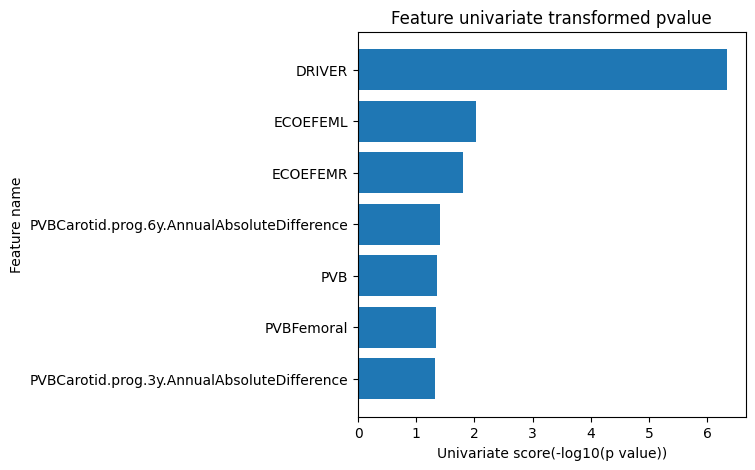

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))

ax.barh(list(pvalues.index.astype(str)), list(-np.log10(pvalues.pvalue.astype(float))))
ax.set_title("Feature univariate transformed pvalue")
ax.set_ylabel("Feature name")
ax.set_xlabel(r"Univariate score(-log10(p value))")
ax.invert_yaxis() 

plt.show()


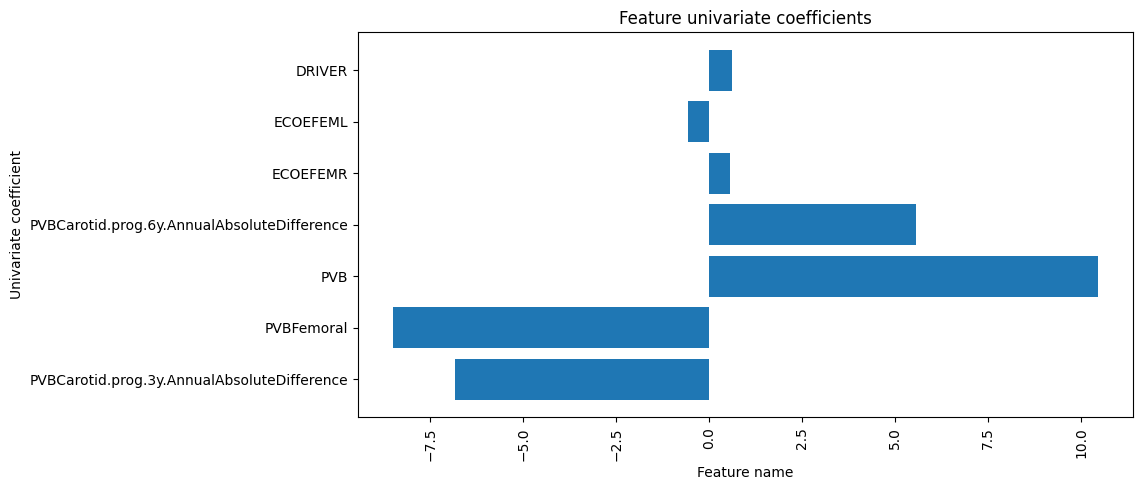

In [26]:

fig, ax = plt.subplots(figsize=(10,5))

ax.barh(list(pvalues.index.astype(str)), pvalues.coef.astype(float))
ax.set_title("Feature univariate coefficients")
ax.set_ylabel("Univariate coefficient")
ax.set_xlabel(r"Feature name")
ax.tick_params(axis='x', labelrotation= 90)
ax.invert_yaxis() 
plt.show()

CADD: Functional prediction scores for non-coding SNVs

LoFtool: Gene unique score, tendency to mutations

PROVEAN: Damaging score (SMALLER MORE DAMAGING)

META: Funtionals prediction scores with diferent methods 

MetaSVM_rankscore: MetaSVM scores were ranked among all MetaSVM scores in dbNSFP. The rankscore is the ratio of the rank of the score over the total number of MetaSVM scores in dbNSFP. The scores range from 0 to 1.

MetaSVM_score; Larger value means the SNV is more likely to be damaging. Scores range from -2 to 3 

STRANDQ: "Phred-scaled quality of strand bias artifact"





In [27]:
print(len(list(pvalues.index)))
list(pvalues.index)

7


['DRIVER',
 'ECOEFEML',
 'ECOEFEMR',
 'PVBCarotid.prog.6y.AnnualAbsoluteDifference',
 'PVB',
 'PVBFemoral',
 'PVBCarotid.prog.3y.AnnualAbsoluteDifference']

In [28]:
y_1 = np.array(df_3['AER']).astype(int)
X = np.array(df_4)
X_1 = pd.DataFrame(df_filtered_imputed_numeric_variance_1)
scaler = preprocessing.StandardScaler()
X_1 = pd.DataFrame(scaler.fit_transform(X_1))
numeric_columns = [item.replace('+', 'plus') for item in numeric_columns]
numeric_columns = [item.replace('-', '_') for item in numeric_columns]

X_1.columns = numeric_columns


In [29]:
X_1_c = sm.add_constant(X_1, prepend=False)
modelo = sm.OLS(endog=y_1, exog=X_1_c)
modelo2 = modelo.fit()
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     2.338
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           2.73e-07
Time:                        15:21:14   Log-Likelihood:                -1733.6
No. Observations:                 430   AIC:                             3605.
Df Residuals:                     361   BIC:                             3886.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
DRIVER                                          4.6574      0.789      5.906      0.000       3.107       6.208
SEQN                                           -0.2456      0.906     -0.271      0.787      -2.028       1.537
FastingGlucose                                 -0.5475      1.517     -0.361      0.718      -3.531       2.436
TotalCholesterol                                4.3218      3.504      1.233      0.218      -2.570      11.213
LDL                                           -13.6810     10.295     -1.329      0.185     -33.926       6.564
HDL                                            -2.6030      1.573     -1.655      0.099      -5.696       0.490
Triglyceride                                   -4.4377      3.789     -1.171      0.242     -11.889       3.013
Insulin                                         2.1425      3.513      0.610      0.542      -4.765       9.050
HbA1c                                           1.2076      1.249      0.967      0.334      -1.249       3.664
GOT                                            -1.4644      1.407     -1.041      0.299      -4.230       1.302
GPT                                             2.1064      1.557      1.352      0.177      -0.956       5.169
GGT                                             0.7333      1.280      0.573      0.567      -1.784       3.251
Erythrocytes                                    2.5212      8.847      0.285      0.776     -14.877      19.919
NeutrophilsPercent                              2.1297     17.903      0.119      0.905     -33.077      37.336
MonocytesPercent                                2.5640      4.401      0.583      0.561      -6.091      11.219
LymphocytesPercent                              5.9084     16.559      0.357      0.721     -26.656      38.473
EosinophilsPercent                              4.0874      4.367      0.936      0.350      -4.501      12.675
Platelets                                      -1.9085      1.736     -1.099      0.272      -5.322       1.505
Neutrophils                                    33.5856     27.173      1.236      0.217     -19.851      87.022
Lymphocytes                                    15.8165     11.731      1.348      0.178      -7.252      38.885
Hemoglobin                                     -3.3707      2.767     -1.218      0.224      -8.813       2.072
Hematocrit                                      0.2356      8.511      0.028      0.978     -16.502      16.973
RDW                                            -0.7163      0.895     -0.800      0.424      -2.476       1.044
MCV                                             1.6959      4.871      0.348      0.728      -7.882      11.274
SerumLipoproteinA                               0.1890     

In [30]:
f = open('LinearFeaturenogene_AER.csv', 'w')
try:
    f.write(modelo2.summary().tables[1].as_csv())
finally:
    f.close()
    
pva = modelo2.pvalues


pva = pd.DataFrame(pva)
pva.columns = ['pvalue']
pva.drop(pva.tail(1).index, 
        inplace = True)
pva

,pvalue
DRIVER,8.093409e-09
SEQN,7.865289e-01
FastingGlucose,7.184391e-01
TotalCholesterol,2.182879e-01
LDL,1.847073e-01
...,...
CAC_diff_v3v1,8.505913e-02
CAC_sqrt_v3v1,2.984519e-01
CAC_prog_MESA,2.137146e-01
dias,6.653658e-01


In [31]:
pvalues = pd.read_csv('LinearFeaturenogene_AER.csv')
pvalues.drop(pvalues.tail(1).index, 
        inplace = True)
pvalues.set_index(X_1.columns, inplace = True)

pvalues = pvalues.drop(pvalues.columns[0], axis= 1)

pvalues.columns = ['coef', 'stderr', 'z', 'pvalue', '0.025', '0.975']

pvalues['pvalue'] = pva['pvalue'].values
pvalues = pvalues.sort_values(by=['pvalue'])
pvalues = pvalues[pvalues['pvalue'].astype(float)< 0.05]
pvalues

,coef,stderr,z,pvalue,0.025,0.975
DRIVER,4.6574,0.789,5.906,8.093409e-09,3.107,6.208
PVBFemoral,-36.4234,9.938,-3.665,2.845155e-04,-55.968,-16.879
PVB,43.8762,12.115,3.622,3.345011e-04,20.052,67.700
ECOEFEML,-4.6068,1.348,-3.418,7.027401e-04,-7.257,-1.956
PVBCarotid.prog.6y.AnnualAbsoluteDifference,21.1436,6.539,3.233,1.336850e-03,8.283,34.004
PVBCarotid,-15.1884,4.705,-3.228,1.359430e-03,-24.441,-5.936
PVB.prog.6y.AnnualAbsoluteDifference,-39.1448,13.016,-3.007,2.819106e-03,-64.741,-13.548
PVBCarotid.prog.3y.AnnualAbsoluteDifference,-24.8290,8.536,-2.909,3.854889e-03,-41.616,-8.042
PVBFemoral.prog.6y.AnnualAbsoluteDifference,33.3271,11.510,2.896,4.015802e-03,10.692,55.962
ECOEFEMR,3.6540,1.305,2.800,5.387150e-03,1.088,6.221


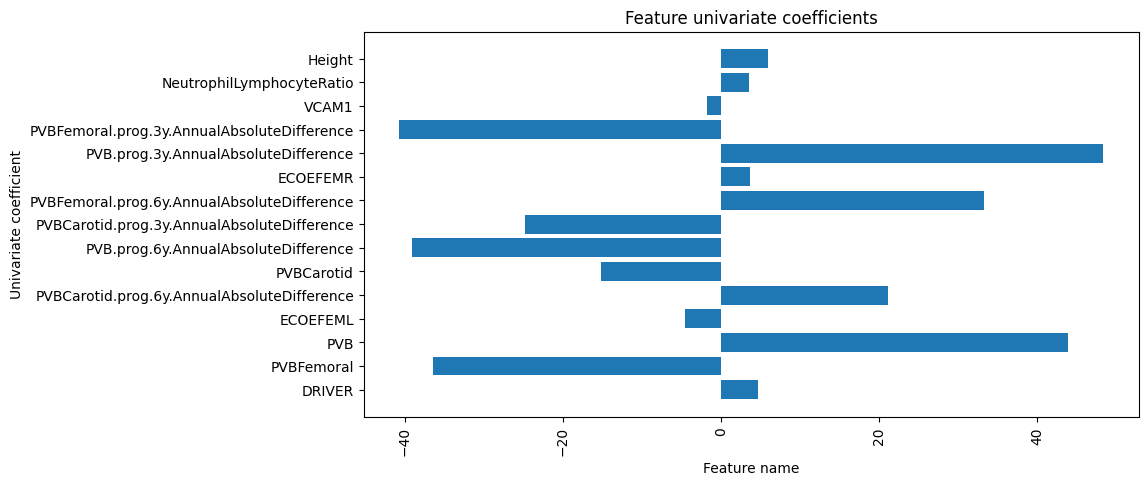

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

ax.barh(list(pvalues.index.astype(str)), pvalues.coef.astype(float))
ax.set_title("Feature univariate coefficients")
ax.set_ylabel("Univariate coefficient")
ax.set_xlabel(r"Feature name")
ax.tick_params(axis='x', labelrotation= 90)

plt.show()

In [33]:
print(len(list(pvalues.index)))
list(pvalues.index)

15


['DRIVER',
 'PVBFemoral',
 'PVB',
 'ECOEFEML',
 'PVBCarotid.prog.6y.AnnualAbsoluteDifference',
 'PVBCarotid',
 'PVB.prog.6y.AnnualAbsoluteDifference',
 'PVBCarotid.prog.3y.AnnualAbsoluteDifference',
 'PVBFemoral.prog.6y.AnnualAbsoluteDifference',
 'ECOEFEMR',
 'PVB.prog.3y.AnnualAbsoluteDifference',
 'PVBFemoral.prog.3y.AnnualAbsoluteDifference',
 'VCAM1',
 'NeutrophilLymphocyteRatio',
 'Height']

MVP predicts the pathogenicity of missense features computed at different scales, per base pair (e.g., amino acid constraint score and conservation), per local context (e.g., protein structure and modification), as well as per gene (e.g., gene mutation intolerance, sub-genic regional depletion of missense variants)

HUVEC_fitCons_score: fitCons score predicts the fraction of genomic positions belonging toa specific function class (defined by epigenomic "fingerprint") that are under selective pressure. Scores range from 0 to 1, with a larger score indicating a higher proportion of nucleic sites of the functional class the genomic position belong to are under selective pressure, therefore more likely to be functional important. GM12878 fitCons scores arebased on cell type HUVEC. More details can be found in doi:10.1038/ng.3196.86 

HUVEC_fitCons_rankscore: HUVEC fitCons scores were ranked among all HUVEC fitConsscores in dbNSFP. The rankscore is the ratio of the rank of the score over the total number of HUVEC fitCons coding scores in dbNSFP.

TLOD: "Log 10 likelihood ratio score of variant existing versus not existing"

ECNT: "Number of events in this haplotype"

STRANDQ: "Phred-scaled quality of strand bias artifact"

Reliability_index: Number of observed component scores (except the maximum frequency inthe 1000 genomes populations) for MetaSVM and MetaLR. Ranges from 1 to 10. As MetaSVM and MetaLR scores are calculated based on imputed data, the less missing component scores, the higher the reliability of the scores and predictions.

GERP++_NR: conservation score

DANN_score: DANN is a functional prediction score retrained based on the training dataof CADD using deep neural network. Scores range from 0 to 1. A larger number indicate a higher probability to be damaging.




## Rendimiento de KNN usando todas las caracteristicas
Llevamos a cabo un proceso de validación cruzada de 10 veces 10-fold para estimar el rendimiento de predicción del clasificador KNN usando todas las caracteristicas. Estandarizamos los datos para que tengan medioa 0 y desviación 1. Posteriormente, elegimos los valores de los hiperparámetros que se espera que funcionen bien. Lo hacemos utilizando un paso de validación cruzada interna, utilizando 5-fold. Utilizamos K-Nearest-Neighbors como clasificador y elegimos el número de vecinos utilizado. Para terminar ajustamos el modelo final y estimamos su rendimiento.

In [34]:
# This is the number of times the 10-fold cv process will be repeated

X = np.array(X_1)
n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#We create an array to store the results

knn_error = np.zeros(10 * n_repeats)

split = 0

for train_index, test_index in rkf.split(X, y):
    
    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()
    
    # First simple variable ranking
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data
    
    # Already done
    
    #Choosing good vales for the number of neighbors
    
    #We create a Pipeline for training the classifier in the inner cross validation procedure.
    
    pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ])
    
    #We specify values for the hyperparameters of the classifier. In this case, the number of neighbors to consider.
    
    N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
    param_grid = { 'knn__n_neighbors': N_neighbors }
    
    #Evaluating the Performance for each Value of the Hyperparameters
    
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train, y_train)
    
    #Obtaining the Results
    
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']
    
    #best parameter value
    
    best_knn = N_neighbors[np.argmax(accuracies)]
    
    #Fitting the Final Model and Estimating Its Performance
    
    knn = KNeighborsClassifier(n_neighbors = best_knn)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    knn_error[split] = 1.0 - np.mean(knn.predict(X_test) == y_test)
    split += 1

....................................................................................................

In [35]:
print("Mean Error KNN:%f" % np.mean(knn_error))
print("\tStd Mean Error KNN:%f" % (np.std(knn_error) / np.sqrt(len(knn_error))))

Mean Error KNN:0.260000
	Std Mean Error KNN:0.006440


## Rendimiento de KNN con selección de características ANOVA

In [36]:
# This is the number of times the 10-fold cv process will be repeated

n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#We create an array to store the results

knn_error_ANOVA = np.zeros(10 * n_repeats)

split = 0

for train_index, test_index in rkf.split(X, y):
    
    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()
    
    # First simple variable ranking
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data
    

    # We filter the data first using SelectKBest
    #Using as a scoring function f_classif
    
    filtering = SelectKBest(f_regression, k = 10)
    filtering.fit(X_train, y_train)
    
    X_train_A = filtering.transform(X_train)
    X_test_A = filtering.transform(X_test)
    
    #We create a Pipeline for training the classifier in the inner cross validation procedure.
    
    pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ])
    
    #We specify values for the hyperparameters of the classifier. 
    #In this case, the number of neighbors to consider.
    
    N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
    param_grid = { 'knn__n_neighbors': N_neighbors }
    
    #Evaluating the Performance for each Value of the Hyperparameters using 5-fold cross validation
    
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train_A, y_train)
    
    #Obtaining the Results
    
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']
    
    #best parameter value
    
    best_knn = N_neighbors[np.argmax(accuracies)]
    
    #Fitting the Final Model and Estimating Its Performance
    
    knn = KNeighborsClassifier(n_neighbors = best_knn)
    knn.fit(X_train_A, y_train)
    
    y_pred = knn.predict(X_test_A)
    knn_error_ANOVA[split] = 1.0 - np.mean(knn.predict(X_test_A) == y_test)
    split += 1

....................................................................................................

In [37]:
print("Mean Error KNN:%f" % np.mean(knn_error_ANOVA))
print("\tStd Mean Error KNN:%f" % (np.std(knn_error_ANOVA) / np.sqrt(len(knn_error_ANOVA))))

Mean Error KNN:0.276512
	Std Mean Error KNN:0.005790


## Rendimiento de KNN usando Random Forest

In [38]:
# This is the number of times the 10-fold cv process will be repeated

n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#We create an array to store the results

knn_error_RF = np.zeros(10 * n_repeats)

split = 0

for train_index, test_index in rkf.split(X, y):
    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()
    
    # First simple variable ranking
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data
    

    
    # We first filter the data first using SelectKBest
    #Using as a scoring function f_classif
    # we keep only the 20% most promising features
    
    filtering = SelectKBest(f_regression, k = int(np.round(X.shape[ 1 ] * 0.2)))
    filtering.fit(X_train, y_train)
    
    X_train_rf = filtering.transform(X_train)
    X_test_rf = filtering.transform(X_test)
    
    # we filter the data again using rf for feature selection
    
    rf_selection =  SelectFromModel(RandomForestClassifier(n_estimators = 200, \
    random_state = 0), threshold = 0.0)
    rf_selection.fit(X_train_rf, y_train)
    rf_selection.threshold = -1.0 * np.sort(-1.0 * rf_selection.estimator_.feature_importances_)[ 9 ]
    
    X_train_rf = rf_selection.transform(X_train_rf)
    X_test_rf = rf_selection.transform(X_test_rf)
    
    #We Choose the best value for the number of neighbors in each cross validation partition with 5 fold cv
    
    pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ])
    
    N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
    param_grid = { 'knn__n_neighbors': N_neighbors }
    
    skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(X_train_rf, y_train)

    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']
    
    #best parameter value
    
    best_knn = N_neighbors[np.argmax(accuracies)]
    
    # We fit the classifiers and compute the test performance
    
    knn = KNeighborsClassifier(n_neighbors = best_knn)
    knn.fit(X_train_rf, y_train)    

    knn_error_RF[ split ] = 1.0 - np.mean(knn.predict(X_test_rf) == y_test)
    
    split += 1


....................................................................................................

In [39]:
print("Mean Error KNN:%f" % np.mean(knn_error_RF))
print("\tStd Mean Error KNN:%f" % (np.std(knn_error_RF) / np.sqrt(len(knn_error_RF))))

Mean Error KNN:0.275349
	Std Mean Error KNN:0.005853


## Performance of the NKK  as a function of the features used for prediction

In [48]:
# This is the number of times the 10-fold cv process will be repeated
X = np.array(X_1)
n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#We set n_features to contain the number of features teste
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(73), 0.1))).astype(np.int))

#We create an array to store the results

knn_error_ANOVA = np.zeros((10 * n_repeats, len(n_features)))
knn_error_random = np.zeros((10 * n_repeats, len(n_features)))

split = 0

for train_index, test_index in rkf.split(X, y):

    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data
    

    # This random array will be used to pick up features at random as a base-line
    # to compare with.
    
    random_features = np.random.permutation(X.shape[ 1 ])

    # For we loop over the number of features to be tested 
    
    for i in range(len(n_features)):
        
        # We create a filter to select the required number of features
        # The filter will be based on the F-statistc "f_classif".

        filtering = SelectKBest(f_regression, k = n_features[ len(n_features) - i - 1 ])
        filtering.fit(X_train, y_train)
        
        # We carry out the feature selection process
        
        X_train_sel = filtering.transform(X_train)
        X_test_sel = filtering.transform(X_test)

        # We fit the classifier on the training data and evaluate its performance on
        # test data. We use k=3

        knn = KNeighborsClassifier(n_neighbors = 3)
        knn.fit(X_train_sel, y_train)
        
        knn_error_ANOVA[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(knn.predict(X_test_sel) == y_test)

        knn.fit(X_train[ :, random_features[ 0 : n_features[ len(n_features) - i - 1 ] ] ], y_train)

        knn_error_random[ split, len(n_features) - i - 1 ] = 1.0 - \
            np.mean(knn.predict(X_test[ :, random_features[ 0 : \
            n_features[ len(n_features) - i - 1 ] ] ]) == y_test)
        
        
    split += 1

....................................................................................................

In [49]:
# We compute mean errors and the corresponding standard deviations

error = np.mean(knn_error_ANOVA, 0)
error_std = np.std(knn_error_ANOVA, 0) / np.sqrt(knn_error_ANOVA.shape[ 0 ])

error_random = np.mean(knn_error_random, 0)
error_random_std = np.std(knn_error_random, 0) / np.sqrt(knn_error_random.shape[ 0 ])

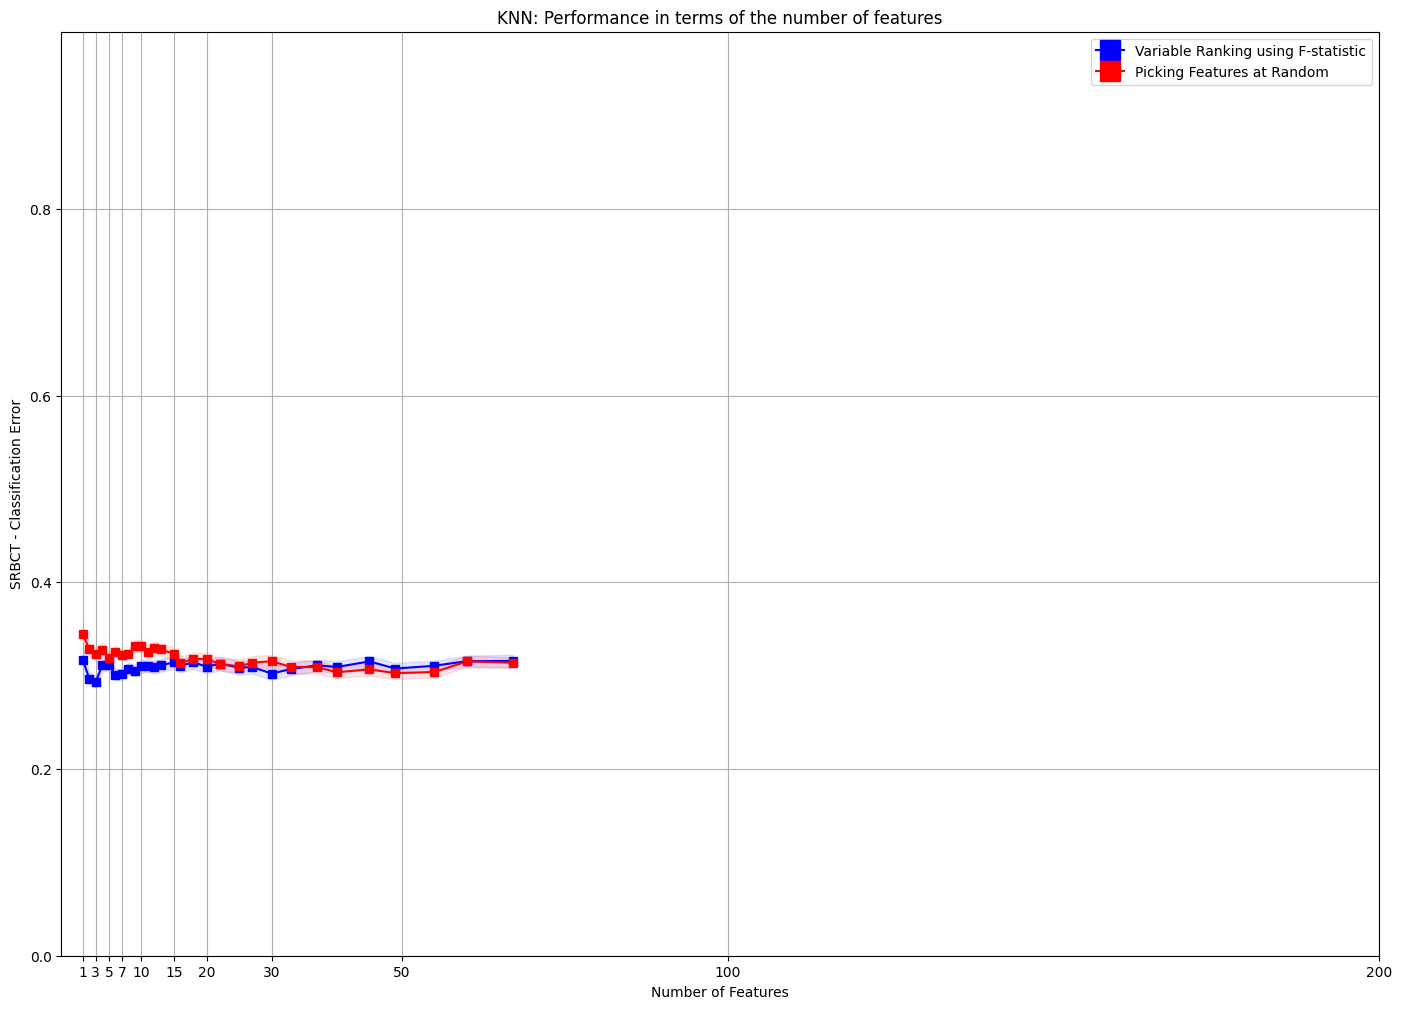

In [50]:
# The axis legend will consdier a subset of the features tested

sel = np.arange(1, len(n_features) + 1, 8) - 1

plt.figure(figsize=(17,12))
line1, = plt.plot(n_features, error, 's-', color="b")
line2, = plt.plot(n_features, error_random, 's-', color="r")
plt.fill_between(n_features, error - error_std, error + error_std, alpha=0.1, color="b")
plt.fill_between(n_features, error_random - error_random_std, \
    error_random + error_random_std, alpha=0.1, color="r")
plt.grid()
plt.title("KNN: Performance in terms of the number of features")
plt.xlabel('Number of Features')
plt.xticks(np.array([1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 200]))
plt.ylabel('SRBCT - Classification Error')
plt.ylim(0,  0.99)
legend_handles = [ mlines.Line2D([], [], color='b', marker='s', \
    markersize=15, label='Variable Ranking using F-statistic'),
    mlines.Line2D([], [], color='r', marker='s', \
    markersize=15, label='Picking Features at Random') ]
plt.legend(handles=legend_handles, loc = 1)
plt.show()

## The feature selection is done externally to the cross-validation loop using all the available data

In [51]:
n_repeats = 10
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#We set n_features to contain the number of features teste
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(73), 0.1))).astype(np.int))

#We create an array to store the results

knn_error_ANOVA1 = np.zeros((10 * n_repeats, len(n_features)))

split = 0

for i in range(len(n_features)):
        
    # We create a filter to select the required number of features
    # The filter will be based on the F-statistc "f_classif".

    filtering = SelectKBest(f_regression, k = n_features[ len(n_features) - i - 1 ])
    filtering.fit(X, y)
    
    X_sel = filtering.transform(X)
    #X_sel = X_1.loc[: ,list(pvalues.index)[-i]] 

for train_index, test_index in rkf.split(X_sel, y):

    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data
    


    # We fit the classifier on the training data and evaluate its performance on
    # test data. We use k=3
        
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train)
        
    knn_error_ANOVA1[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(knn.predict(X_test) == y_test)
  
    split += 1

....................................................................................................

In [52]:
# We compute mean errors and the corresponding standard deviations

error1 = np.mean(knn_error_ANOVA1, 0)
error1_std = np.std(knn_error_ANOVA1, 0) / np.sqrt(knn_error_ANOVA1.shape[ 0 ])


In [53]:
error

array([0.31697674, 0.29697674, 0.29348837, 0.31116279, 0.31186047,
       0.30116279, 0.30162791, 0.30744186, 0.3055814 , 0.31      ,
       0.31069767, 0.30930233, 0.31116279, 0.3144186 , 0.31069767,
       0.3144186 , 0.30953488, 0.31302326, 0.30860465, 0.30930233,
       0.30232558, 0.3072093 , 0.31116279, 0.30930233, 0.31534884,
       0.30767442, 0.31069767, 0.3155814 , 0.31581395])

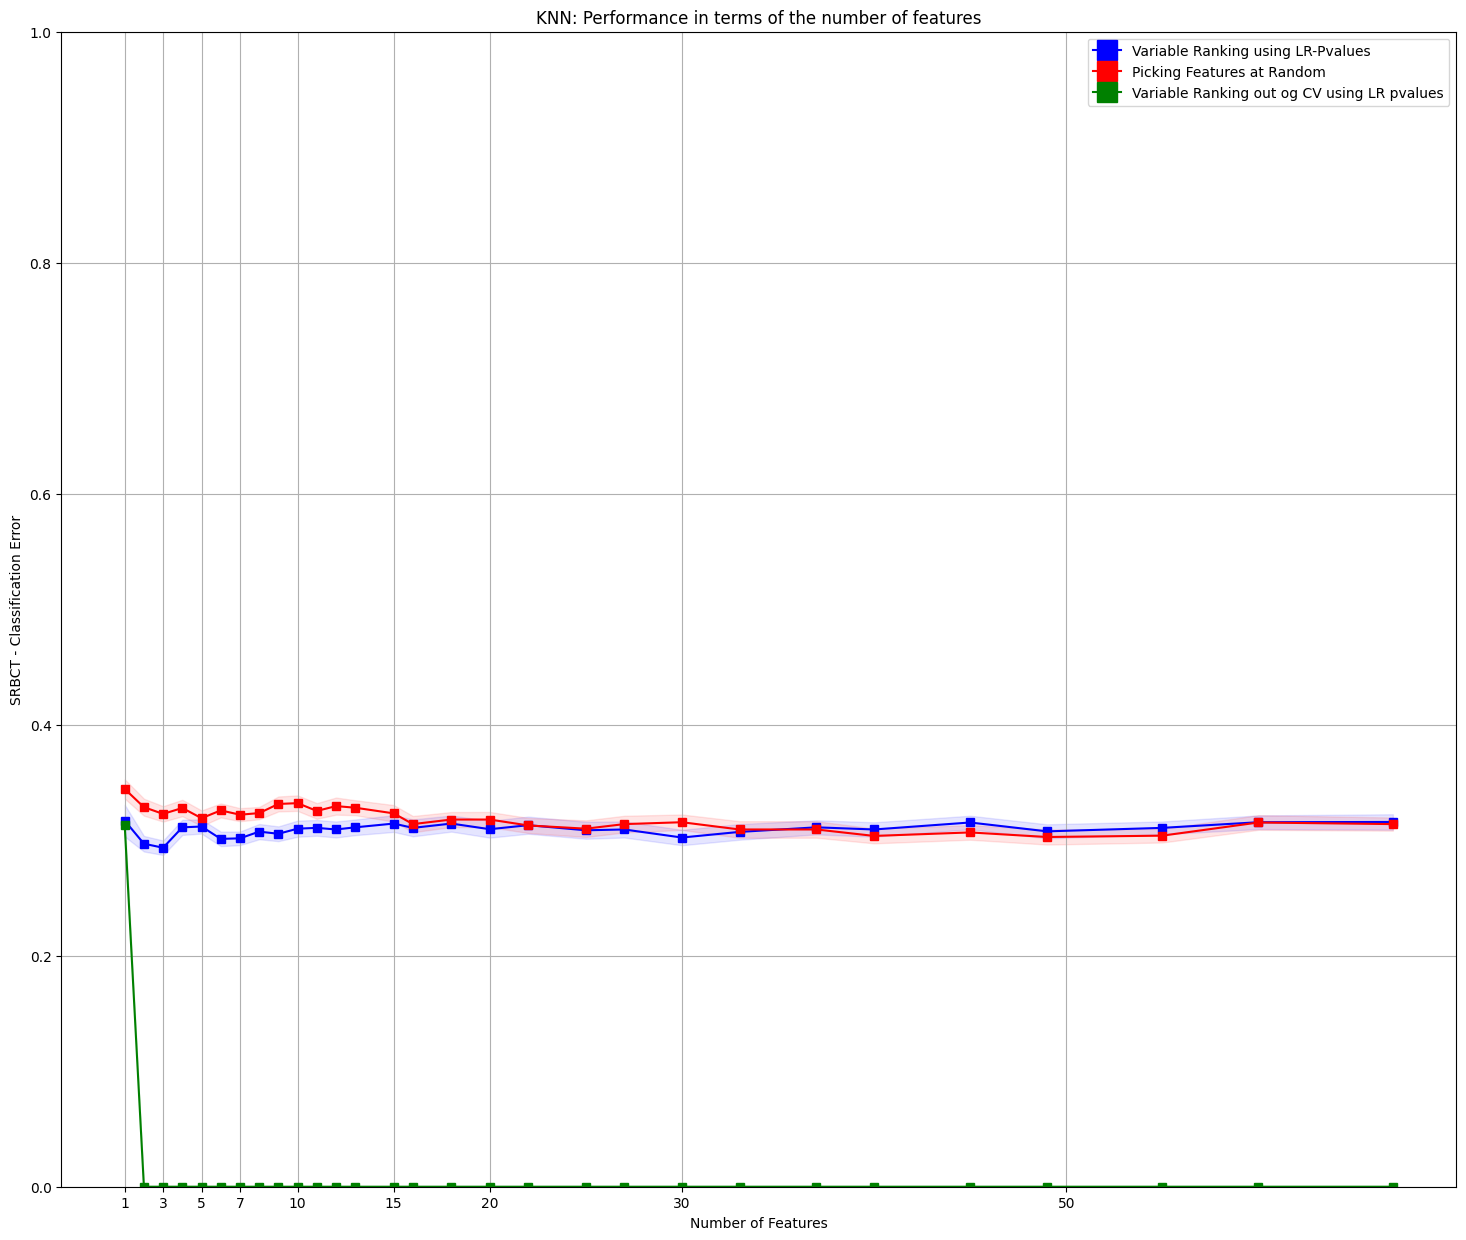

In [54]:
# The axis legend will consdier a subset of the features tested

sel = np.arange(1, len(n_features) + 1, 16) - 1

plt.figure(figsize=(18,15))
line1, = plt.plot(n_features, error, 's-', color="b")
line2, = plt.plot(n_features, error_random, 's-', color="r")
line3, = plt.plot(n_features, error1, 's-', color="g")
plt.fill_between(n_features, error - error_std, error + error_std, alpha=0.1, color="b")
plt.fill_between(n_features, error_random - error_random_std, \
    error_random + error_random_std, alpha=0.1, color="r")
plt.fill_between(n_features, error1 - error1_std, error1 + error1_std, alpha=0.1, color="g")
plt.grid()
plt.title("KNN: Performance in terms of the number of features")
plt.xlabel('Number of Features')
plt.xticks(np.array([1, 3, 5, 7, 10, 15, 20, 30, 50]))
plt.ylabel('SRBCT - Classification Error')
plt.ylim(0,  1)
legend_handles = [ mlines.Line2D([], [], color='b', marker='s', \
    markersize=15, label='Variable Ranking using LR-Pvalues'),
    mlines.Line2D([], [], color='r', marker='s', \
    markersize=15, label='Picking Features at Random'), 
    mlines.Line2D([], [], color='g', marker='s', \
    markersize=15, label='Variable Ranking out og CV using LR pvalues')]
plt.legend(handles=legend_handles, loc = 1)
plt.show()

In [55]:
print('El menor error se consigue con el numero de caracteristicas: %f' % n_features[np.argmin(error)])

El menor error se consigue con el numero de caracteristicas: 3.000000


##  particular features should be used for prediction on this dataset.

In [56]:
important_features = {}
scores = {}
n_repeats = 10
features = X_1.columns.values
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

#We set n_features to contain the number of features teste
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(73), 0.1))).astype(np.int))

#We create an array to store the results

knn_error_ANOVA = np.zeros((10 * n_repeats, len(n_features)))
knn_error_random = np.zeros((10 * n_repeats, len(n_features)))

split = 0

for train_index, test_index in rkf.split(X, y):

    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data
    

    
    # This random array will be used to pick up features at random as a base-line
    # to compare with.
    
    random_features = np.random.permutation(X.shape[ 1 ])

    # For we loop over the number of features to be tested 
    
    for i in range(len(n_features)):
        
        # We create a filter to select the required number of features
        # The filter will be based on the F-statistc "f_classif".

        filtering = SelectKBest(f_regression, k = n_features[ len(n_features) - i - 1 ])
        filtering.fit(X_train, y_train)
        
        # We carry out the feature selection process
        
        X_train_sel = filtering.transform(X_train)
        X_test_sel = filtering.transform(X_test)
        

        #we keep the position of the best features
        features = np.array(features)
        filter = filtering.get_support(indices=True)
        
        #we build a dictionary that contains the best features as a function of the n_feature used
        important_features[n_features[-(i+1)]]=features[filter]
        scores[n_features[-(i+1)]] = -np.log10(filtering.pvalues_[filter])


....................................................................................................

In [57]:
important_features[int(n_features[np.argmin(error)])]

array(['DRIVER', 'ECOECARL', 'ECOEFEML'], dtype=object)

In [58]:
scores[int(n_features[np.argmin(error)])]

array([10.34942118,  1.29410323,  1.34668239])

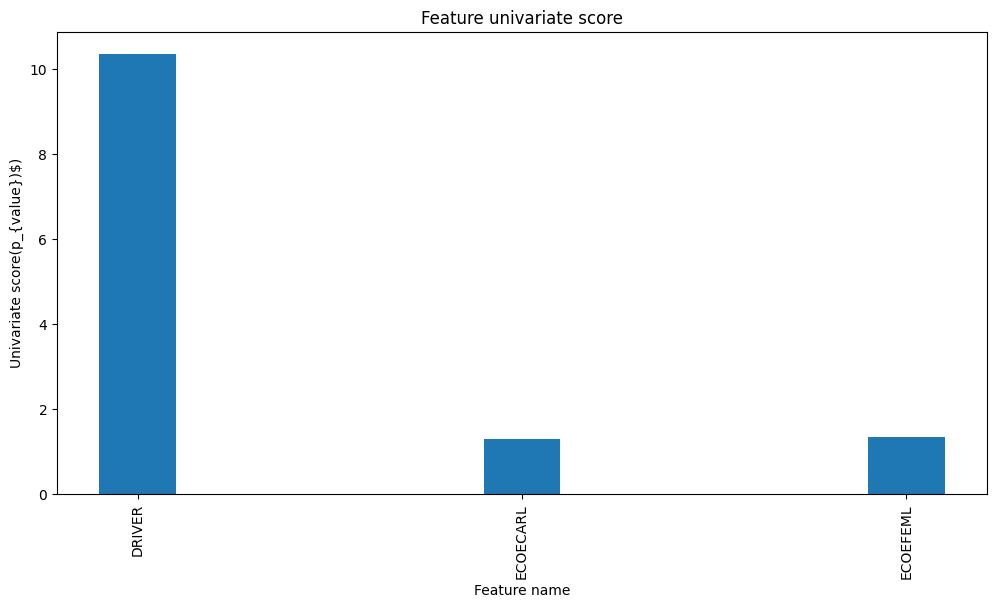

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(important_features[int(n_features[np.argmin(error)])], scores[int(n_features[np.argmin(error)])], width=0.2, linewidth=0.7)
plt.title("Feature univariate score")
plt.xlabel("Feature name")
plt.ylabel(r"Univariate score(p_{value})$)")

plt.xticks(rotation=90)
plt.show()



['DRIVER' 'SEQN' 'FastingGlucose' 'LDL' 'HDL' 'Triglyceride' 'Insulin'
 'GPT' 'GGT' 'NeutrophilsPercent' 'MonocytesPercent' 'LymphocytesPercent'
 'Platelets' 'Neutrophils' 'Lymphocytes' 'Hematocrit' 'RDW' 'MCV'
 'SerumLipoproteinA' 'HSCReactiveProtein' 'VCAM1' 'PSelectin' 'OXLDL'
 'Leukocytes' 'BMI' 'SBP' 'Weight' 'HOMA_IR' 'NeutrophilLymphocyteRatio'
 'FibrinogenPSelectinRatio' 'FattyLiverIndex' 'INFLAScorePESA'
 'CholesterolNonHDL' 'TAC_v1v3_years' 'dias' 'AGE'] 36


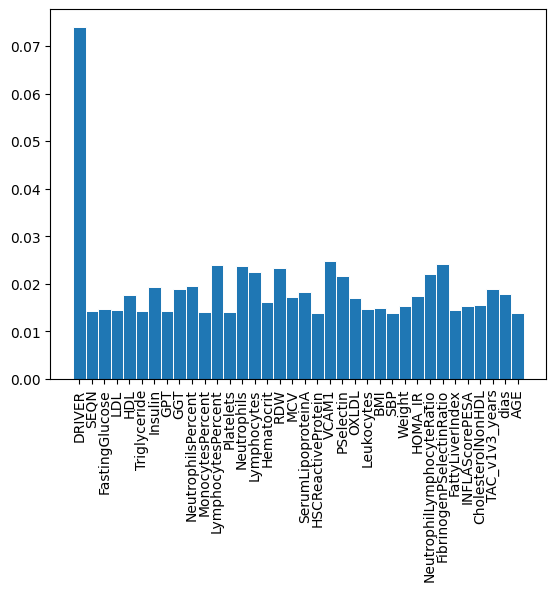

In [60]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

features = X_1.columns.values
LR = RandomForestClassifier()
Fselection = SelectFromModel(estimator = LR)
Fselection.fit(X_1, y)
print(Fselection.get_feature_names_out(input_features=features),
      len(Fselection.get_feature_names_out(input_features=features)))

fig, ax = plt.subplots()
fe = np.array(features)

coef = np.array(Fselection.estimator_.feature_importances_)
ax.bar(fe[Fselection.get_support()], coef[Fselection.get_support()], width=1, edgecolor="white", linewidth=0.7)
plt.xticks(rotation=90)
plt.show()


['DRIVER' 'HDL' 'MonocytesPercent' 'LymphocytesPercent' 'Lymphocytes'
 'VCAM1' 'PSelectin' 'OXLDL' 'Age' 'ECOECARL' 'ECOEFEML' 'ECOEFEMR'
 'ECOEILIR' 'Height' 'FibrinogenPSelectinRatio'
 'PVBCarotid.prog.6y.AnnualAbsoluteDifference'
 'PVBFemoral.prog.6y.AnnualAbsoluteDifference' 'TAC_v1v3_years' 'dias'
 'AGE'] 20


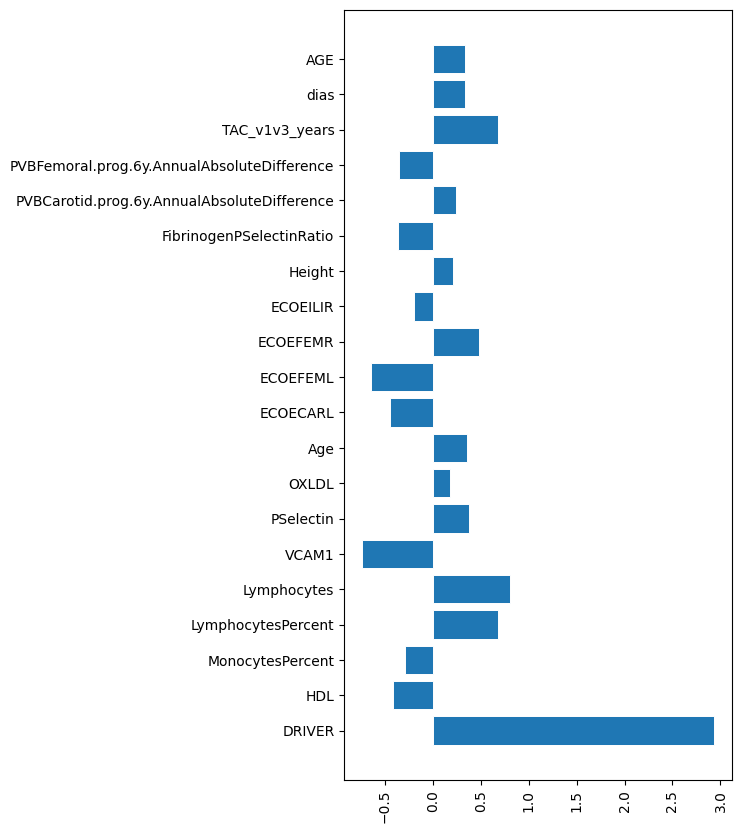

In [61]:
from sklearn.linear_model import ElasticNet

features = X_1.columns.values
Fselection = SelectFromModel(estimator = ElasticNet())
Fselection.fit(X_1, y_1)
print(Fselection.get_feature_names_out(input_features=features), 
      len(Fselection.get_feature_names_out(input_features=features)))
fig, ax = plt.subplots(figsize=(5,10))
fe = np.array(features)
coef = np.array(Fselection.estimator_.coef_)
ax.barh(fe[Fselection.get_support()], coef[Fselection.get_support()], edgecolor="white", linewidth=0.7)
plt.xticks(rotation=90)

plt.show()

